In [1]:
import numpy as np
import scipy.linalg as la
import utils
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rc('font', size=14)

## Van der Pol

### Simuate the system

In [2]:
mu=5
tau=1
x0 = [2.0, 0.0]

period_length = 11.45015*tau

num_periods_simulate = 15
sampling_rate_simulate = 2048
t_simulate_full = np.linspace(0, num_periods_simulate*period_length,
                         int(num_periods_simulate*sampling_rate_simulate))
dt_simulate = t_simulate_full[1]-t_simulate_full[0]

vdp_simulation = utils.simulate_vanderpol_oscillator(dt_simulate, t_simulate_full.size, x0=x0, mu=mu, tau=tau)[0]

initial_samples = int(5*sampling_rate_simulate)
t_simulate = t_simulate_full[:-initial_samples]
vdp_solution = vdp_simulation[0:1,initial_samples:]

### Subsample to get training data

In [3]:
num_periods_subsample = 5
sampling_rate_subsample = 128

t_max_idx = int(num_periods_subsample*period_length/dt_simulate)+2
spacing = sampling_rate_simulate//sampling_rate_subsample

t_sample = t_simulate[:t_max_idx:spacing]
dt_sample = t_sample[1] - t_sample[0]

training_data = vdp_solution[:,:t_max_idx:spacing]

### Train a HAVOK model

In [4]:
time_delay=128
time_delay_spacing=1
rank=24

dmd = utils.DMD(truncation='hard', threshold=rank, time_delay=time_delay, time_delay_spacing=time_delay_spacing)
dmd.fit(training_data, dt_sample)
dmd_reconstruction = dmd.reconstruct(t_simulate, imaginary_evals=True)

### Plot reconstruction, linear model, and power spectrum

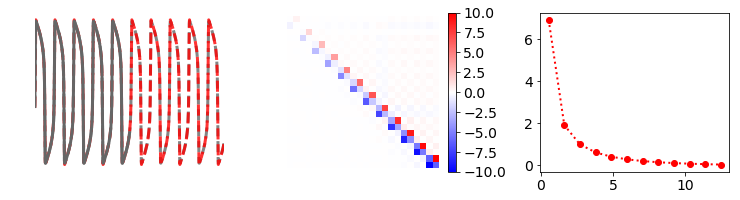

In [5]:
plt.figure(figsize=(10.5,3))
plt.subplot(1,3,1)
plt.plot(t_simulate, vdp_solution[0], '--', color='#666666', alpha=0.8, linewidth=3)
plt.plot(t_simulate, dmd_reconstruction[0], '--', alpha=0.8, linewidth=3, color='red')
plt.plot(t_sample, training_data[0], linewidth=3, color='#666666')
plt.xlim([0*period_length, 10*period_length])
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(np.real(dmd.Atilde_continuous), interpolation='nearest', cmap=plt.get_cmap('bwr'))
plt.axis('off')
plt.colorbar()
plt.clim([-10,10])

idxs = np.argsort(dmd.omega[1])
idxs = idxs[int(np.ceil(idxs.size/2)):]

plt.subplot(1,3,3)
plt.plot(dmd.omega[1,idxs], np.abs(dmd.b[idxs]), 'o:', color='red', linewidth=2)
plt.tight_layout()

# plt.savefig('figures/05a_vdp_havok.pdf', format='pdf', dpi=300)

## Consider how rank affects Van der Pol model

(0, 2, 0.7333333333333334)
(1, 4, 0.6666666666666666)
(2, 8, 0.5333333333333333)
(3, 16, 0.2666666666666666)
(4, 24, 0)


(-2.8623511308148055,
 60.109373747110915,
 -2.3733834047890938,
 2.3731189737516791)

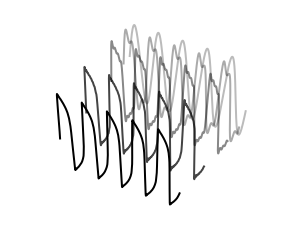

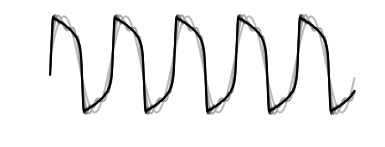

In [6]:
time_delay=128
time_delay_spacing=1
ranks = [2,4,8,16,24]
dmd_reconstructions = np.zeros((len(ranks), t_simulate.size))

for i,rank in enumerate(ranks):
    dmd = utils.DMD(truncation='hard', threshold=rank, time_delay=time_delay, time_delay_spacing=time_delay_spacing)
    dmd.fit(training_data[0:1], dt_sample)
    dmd_reconstructions[i] = dmd.reconstruct(t_simulate, imaginary_evals=True)

T_max = 5*period_length
xx,yy = np.meshgrid(ranks, t_simulate[t_simulate<T_max])

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')
for i,rank in enumerate(ranks):
    ax.plot(t_simulate[t_simulate<T_max],
            -rank+0*t_simulate[t_simulate<T_max],
            dmd_reconstructions[i,t_simulate<T_max],
            alpha=min(.8*rank/ranks[-1]+.2,1), linewidth=2, color='k')
ax.view_init(elev=50, azim=-60)
ax.axis('off')
# plt.savefig('figures/05a_vdp_rank3d.pdf', format='pdf', dpi=300)

plt.figure(figsize=(6,2))
for i,rank in enumerate(ranks):
    color_val=max(1-(.8*rank/ranks[-1]+.2),0)
    print((i,rank,color_val))
    plt.plot(t_simulate[t_simulate<T_max], dmd_reconstructions[i,t_simulate<T_max].T,
            color=[color_val,color_val,color_val], linewidth=2)
plt.axis('off')
# plt.savefig('figures/05a_vdp_rank2d.pdf', format='pdf', dpi=300)

## Consider how number of delays affects Van der Pol model

(-0.5, 20)

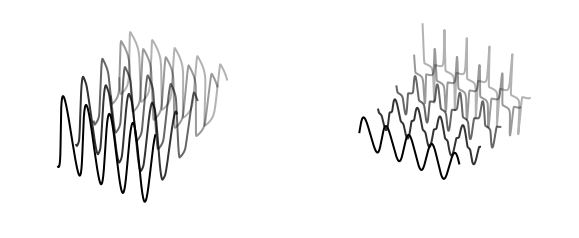

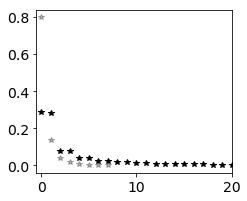

In [7]:
time_delay_spacing=1
delays = [8,16,32,48,64]

modes = []
singular_values = []

for i,time_delay in enumerate(delays):
    H = utils.hankel_matrix(training_data[0:1], time_delay)
    U,s,Vt = la.svd(H, full_matrices=False)
    modes.append(Vt[0:2])
    singular_values.append(s)

T_max = 5*period_length
xx,yy = np.meshgrid(ranks, t_simulate[t_simulate<T_max])

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
for i,time_delay in enumerate(delays):
    mode_size = modes[i].shape[1]
    
    ax1.plot(np.arange(mode_size),
            -time_delay+np.zeros(mode_size),
            modes[i][0],
            alpha=.8*time_delay/delays[-1]+.2, linewidth=2, color='k')
    
    ax2.plot(np.arange(mode_size),
            -time_delay+np.zeros(mode_size),
            modes[i][1],
            alpha=.8*time_delay/delays[-1]+.2, linewidth=2, color='k')
ax1.view_init(elev=50, azim=-60)
ax2.view_init(elev=50, azim=-60)
ax1.axis('off')
ax2.axis('off')
# plt.savefig('figures/05a_vdp_delays3d.pdf', format='pdf', dpi=300)

plt.figure(figsize=(3.5,3))
plt.plot(singular_values[0]/np.sum(singular_values[0]), '*k', alpha=0.3)
plt.plot(singular_values[-1]/np.sum(singular_values[-1]), '*k')
plt.xlim([-.5,20])
# plt.savefig('figures/05a_vdp_singularvalues.pdf', format='pdf', dpi=300)

## Lorenz (periodic)

### Simulate the system

In [8]:
sigma = 10
beta = 8/3
rho = 160
tau = 1

x0 = [.1,.1,100]

period_length = 1.154*tau

num_periods_simulate = 50
sampling_rate_simulate = 4096
t_simulate_full = np.linspace(0, num_periods_simulate*period_length,
                         int(num_periods_simulate*sampling_rate_simulate))
dt_simulate = t_simulate_full[1]-t_simulate_full[0]

lorenz_simulation = utils.simulate_lorenz(dt_simulate, t_simulate_full.size, x0=x0, sigma=sigma, rho=rho, beta=beta,
                                    tau=tau)[0]

initial_samples = int(10*sampling_rate_simulate)
t_simulate = t_simulate_full[:-initial_samples]
lorenz_solution = lorenz_simulation[0:1,initial_samples:]

### Subsample to get training data

In [9]:
num_periods_subsample = 5
sampling_rate_subsample = 128

t_max_idx = int(num_periods_subsample*period_length/dt_simulate)+2
spacing = sampling_rate_simulate//sampling_rate_subsample

t_sample = t_simulate[:t_max_idx:spacing]
dt_sample = t_sample[1] - t_sample[0]

training_data = lorenz_solution[:,:t_max_idx:spacing]

### Train a HAVOK model

In [10]:
time_delay=128
time_delay_spacing=1
rank=12

dmd = utils.DMD(truncation='hard', threshold=rank, time_delay=time_delay, time_delay_spacing=time_delay_spacing)
dmd.fit(training_data, dt_sample)
dmd_reconstruction = dmd.reconstruct(t_simulate, imaginary_evals=True)

### Plot reconstruction, linear model, and power spectrum

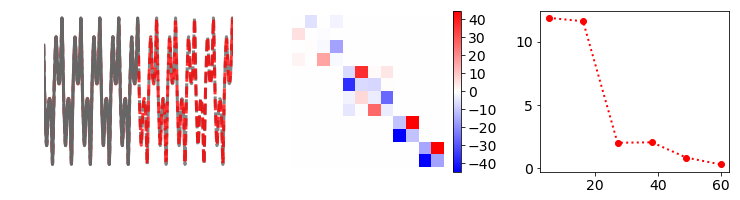

In [11]:
plt.figure(figsize=(10.5,3))
plt.subplot(1,3,1)
plt.plot(t_simulate, lorenz_solution[0], '--', color='#666666', alpha=0.8, linewidth=3)
plt.plot(t_simulate, dmd_reconstruction[0], '--', alpha=0.8, linewidth=3, color='red')
plt.plot(t_sample, training_data[0], linewidth=3, color='#666666')
plt.xlim([0*period_length, 10*period_length])
plt.axis('off')

idxs = np.argsort(dmd.omega[1])
idxs = idxs[int(np.ceil(idxs.size/2)):]

plt.subplot(1,3,2)
plt.imshow(np.real(dmd.Atilde_continuous), interpolation='nearest', cmap=plt.get_cmap('bwr'))
plt.axis('off')
plt.colorbar()
plt.clim([-45,45])

plt.subplot(1,3,3)
plt.plot(dmd.omega[1,idxs], np.abs(dmd.b[idxs]), 'o:', color='red', linewidth=2)
plt.tight_layout()

# plt.savefig('figures/05a_lorenz_havok.pdf', format='pdf', dpi=300)

## Rossler (periodic)

### Simulate the system

In [12]:
a = 0.1
b = 0.1
c = 8.5
tau=.1

x0 = [0,10,0]

period_length = 25.259*tau

num_periods_simulate = 50
sampling_rate_simulate = 4096
t_simulate_full = np.linspace(0, num_periods_simulate*period_length,
                         int(num_periods_simulate*sampling_rate_simulate))
dt_simulate = t_simulate_full[1]-t_simulate_full[0]

rossler_simulation = utils.simulate_rossler(dt_simulate, t_simulate_full.size, x0=x0, a=a, b=b, c=c, tau=tau)[0]

initial_samples = int(5*sampling_rate_simulate)
t_simulate = t_simulate_full[:-initial_samples]
rossler_solution = rossler_simulation[2:3,initial_samples:]

### Subsample to get training data

In [13]:
num_periods_subsample = 5
sampling_rate_subsample = 128

t_max_idx = int(num_periods_subsample*period_length/dt_simulate)+2
spacing = sampling_rate_simulate//sampling_rate_subsample

t_sample = t_simulate[:t_max_idx:spacing]
dt_sample = t_sample[1] - t_sample[0]

training_data = rossler_solution[:,:t_max_idx:spacing]

### Train a HAVOK model

In [14]:
time_delay=128
time_delay_spacing=1
rank=105

dmd = utils.DMD(truncation='hard', threshold=rank, time_delay=time_delay, time_delay_spacing=time_delay_spacing)
dmd.fit(training_data, dt_sample)
dmd_reconstruction = dmd.reconstruct(t_simulate, imaginary_evals=True)

### Plot reconstruction, linear model, and power spectrum

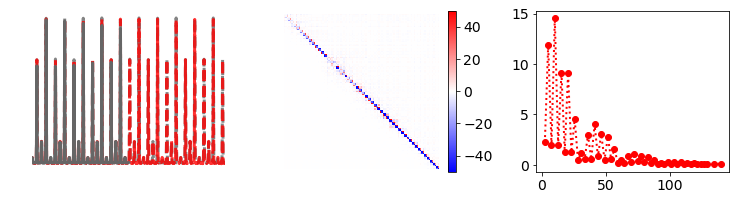

In [15]:
plt.figure(figsize=(10.5,3))
plt.subplot(1,3,1)
plt.plot(t_simulate, rossler_solution[0], '--', color='#666666', alpha=0.8, linewidth=3)
plt.plot(t_simulate, dmd_reconstruction[0], '--', alpha=0.8, linewidth=3, color='red')
plt.plot(t_sample, training_data[0], linewidth=3, color='#666666')
plt.xlim([0*period_length, 10*period_length])
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(np.real(dmd.Atilde_continuous), interpolation='nearest', cmap=plt.get_cmap('bwr'))
plt.axis('off')
plt.colorbar()
plt.clim([-50,50])

idxs = np.argsort(dmd.omega[1])
idxs = idxs[int(np.ceil(idxs.size/2)):]

plt.subplot(1,3,3)
plt.plot(dmd.omega[1,idxs], np.abs(dmd.b[idxs]), 'o:', color='red', linewidth=2)
plt.tight_layout()

# plt.savefig('figures/05a_rossler_havok.pdf', format='pdf', dpi=300)